# <center>DSCI 100 Group 22 Project Report</center>

# <center>Classifier for Sonar Detection of Naval Mines vs Rocks</center>

## Indroduction

Sonar (short for sound navigation and ranging) is a technique which utilizes sound propagation to develop nautical charts. This tool is most commonly implemented underwater to measure distances and communicate with/detect objects on or below the ocean surface. The focus of this project will be the Solar, Mines vs Rocks data set. The file consists of 111 patterns produced by sonar signals bouncing off a metal cylinder and 97 patterns off of rocks. These signals were obtained via varying aspect angles at 90 degrees (cylinder) and 180 degrees (rock). The broadcasted sonar signal was a frequency-modulated chirp, with increasing frequency. Each pattern is a set of 60 numbers in the range 0.0 to 1.0. The numbers indicate the energy within a specific frequency band, integrated over a certain period of time. The label corresponding to each record contains either the letter “R’ for rock objects or “M” for mines (metal cylinder). The numbers within labels appear in increasing arrangement of aspect angles, but do not encode the angle directly. The problem at hand revolves around the question: “is a specific sonar signal bounced off a metal cylinder or roughly cylindrical rock?”. To address this inquiry, throughout this project, a classification model will be developed to predict metal or rock objects from the sonar return data. 

## Methods

First, we loaded our Sonar Data set in directly from the website via its url; read_csv was used to accomplish this. The dataset from the website does not have column names so we set col_names to FALSE in the argument. This will assign column names as “X” followed by the number of the column. We did not see any purpose in renaming the individual bands, however, the very last column denotes the “type” so is renamed as such. The mutate() and as_factor() functions are also implemented to convert our “type” column from a vector object to a statistical categorical variable.

In [3]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:
sonar_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data" 

# does rename successfully but does not show in the red box
sonar_data <- read_csv(sonar_url, col_names = FALSE) |> 
    rename(type = X61) |>
    mutate(type = as_factor(type))

Rows: 208 Columns: 61
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): X61
dbl (60): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling data

Our initial plan was to wrangle the dataset to have three columns: **band**(a factor in range from X1 to X60), **value**(0.0 to 1.0) and **type**(will be a factor; rocks(R) or mines(M)). However, after talking to the TA and facing difficulty in choosing appropriate inputs/predictors, we have decided to leave the dataset as is and have **bands** ranging from **X1** to **X60** in separate columns, and the last columns as X61 to be renamed as **type** with the same description as above. Moreover, we have decided to shuffle the data as it was arranged to be rocks and then mines for later use.


In [5]:
# shuffling data since it is arranged as R then M
set.seed(9999)
sonar_set <- sonar_data[sample(1:nrow(sonar_data)), ]

### Exploratory data analysis(tables)

**Summary of exploration below all the code cells**

In [6]:
# verifying if the set matches the description
verify_count <- sonar_set |> 
    group_by(type)|>
    summarize(n())

verify_count

type,n()
<fct>,<int>
R,97
M,111


- We matched the number of all the rocks and mines with the descriptions; matches

In [7]:
empty_obs <- colSums(is.na(sonar_set))

empty_obs

X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  X11  X12  X13  X14  X15  X16 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 X17  X18  X19  X20  X21  X22  X23  X24  X25  X26  X27  X28  X29  X30  X31  X32 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 X33  X34  X35  X36  X37  X38  X39  X40  X41  X42  X43  X44  X45  X46  X47  X48 
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 
 X49  X50  X51  X52  X53  X54  X55  X56  X57  X58  X59  X60 type 
   0    0    0    0    0    0    0    0    0    0    0    0    0

- We checked for empty cells in column; no empty cells

In [8]:
rock_10_band_mean <- sonar_set |>
    filter(type == "R")|>
    select(X1:X10) |>
    map(mean) |>
    data.frame()
rock_10_band_mean

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02249794,0.03030309,0.03595052,0.04144742,0.06202784,0.09622371,0.1141804,0.1175959,0.1373918,0.1593247


In [9]:
mine_10_band_mean <- sonar_set |>
    filter(type == "M")|>
    select(X1:X10) |>
    map(mean) |>
    data.frame()
mine_10_band_mean

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.03498919,0.04554414,0.05071982,0.06476757,0.08671532,0.111864,0.1283586,0.1498324,0.2134919,0.2510216


- Means of the first 10 bands of each type; both have an increasing trend but stronger in mines. Further relation explored ahead.

### Exploratory data analysis (visual)

- We want to see if the two types have distinct distributions, so that we can distinguish between them through knn model analysis.


In [10]:
rock_mean <- sonar_set |>
    filter(type == "R")|>
    select(-type) |>
    map(mean) |>
    data.frame()
rock_mean["type"] <- c("R")

mine_mean <- sonar_set |>
    filter(type == "M")|>
    select(-type) |>
    map(mean) |>
    data.frame()
mine_mean["type"] <- c("M")

plot_data <- rbind(rock_mean, mine_mean) |>
    pivot_longer(X1:X60, names_to = "band", values_to = "value")|>
    mutate(band = as_factor(band))

The data frames "rock_mean" and "mine_mean" were created by:
- filtering the "sonar_set" data based on the "type" column ("R" for rock and "M" for mine)
- calculating the mean of each column using the "map(mean)" function
- converting the results into data frames with data.frame()

The "rock_mean" and "mine_mean" data frames were then given a "type" column with values "R" for "rock_mean" and "M" for "mine_mean". 

The "plot_data" data frame was created by combining the "rock_mean" and "mine_mean" data frames using "rbind()" and tidied. The "band" column was also converted into a factor using "mutate(band = as_factor(band))".

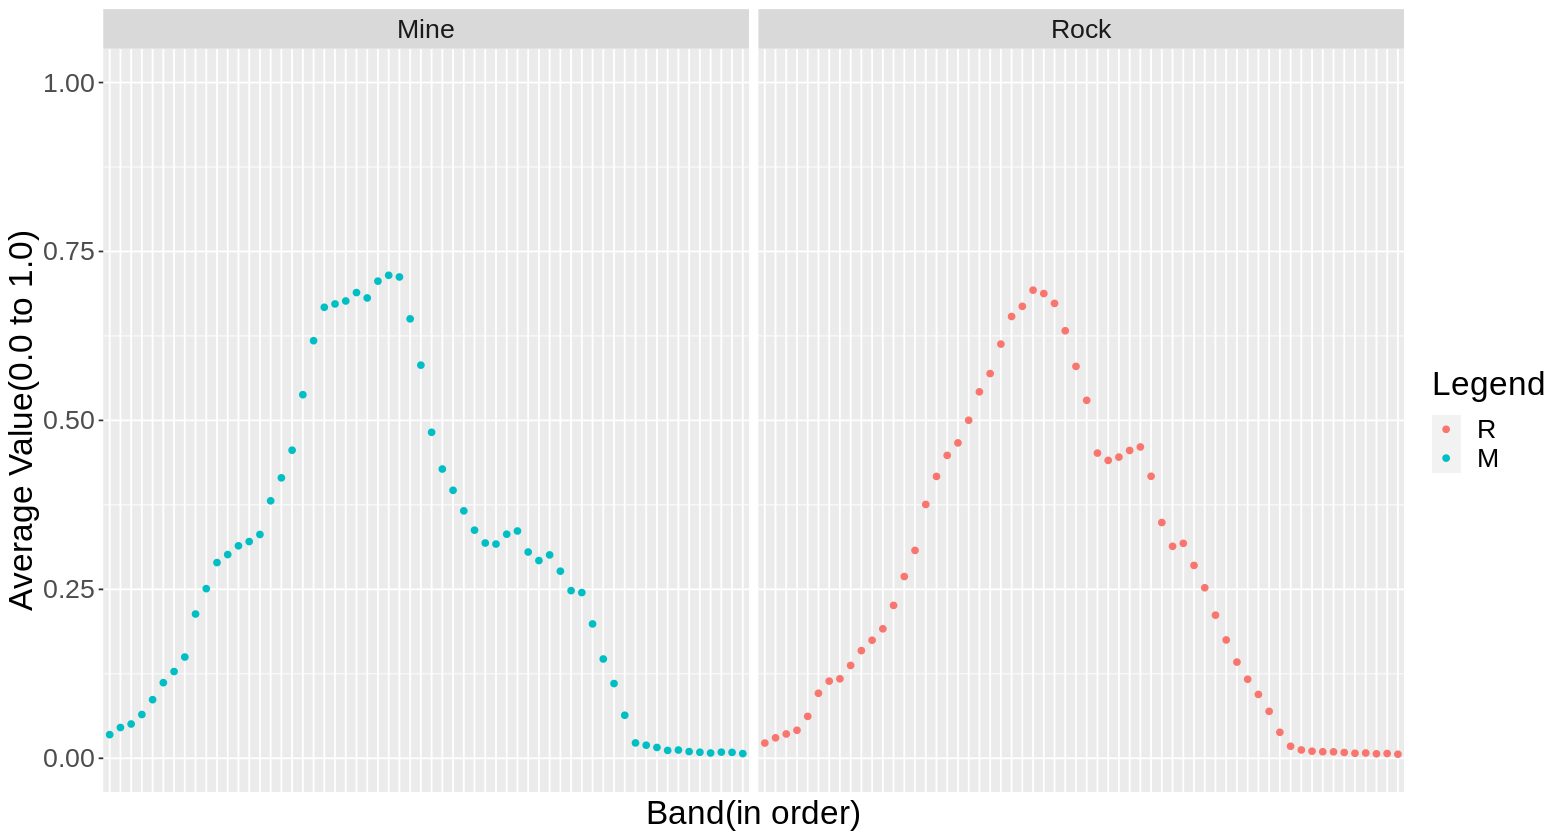

In [2]:
options(repr.plot.width = 13) 
# plot_data
mean_plot <- plot_data |>
    ggplot(aes(x = band, y = value, color = as_factor(type))) +
    geom_point() + 
    facet_grid(cols = vars(type), labeller = as_labeller(c(M = "Mine", R = "Rock"))) +
    labs(x = "Band(in order)", y = "Average Value(0.0 to 1.0)", color = "Legend") +
    ylim(0.0, 1.0)+
# scale_x_continuous(limits = c(1, 60))+
    theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank(), 
        text = element_text(size=20))
mean_plot

The combined plot_data data frame was visualized as a scatterplot by:

a. Plotting the "band" colomn along the x-axis against its corresponding average value ranging from 0.0 to 1.0 along the y-axis by the aes() function

b. Using "color = as_factor(type)" to specify graphic colors according to the factor "type" (i.e. "R" or "M")

c. Creating a multi-axis grid with subplots illustrating the distribution of separate variables ("Mine" and "Rock") of the data set using facet_grid()

- The last 11 bands do not show significant difference in pattern or trend of between rocks and mines. 
- We can omit these last 11 bands; we can also verify this through accuracy result below

In [9]:
# splitting the data

sonar_split <- initial_split(sonar_set, prop = 0.75, strata = type)
sonar_train <- training(sonar_split)
sonar_test <- testing(sonar_split)

- The initial_split function is used to create training and testing sets
- It is specified that "prop = 0.75" so that 75% of our original data set ends up in the training set
- The strata argument is set to the categorical label variable (here, type) to ensure that the training and testing subsets contain the right proportions of each category of observation
- The training() and testing() functions extract the training and testing data sets into two separate data frames

In [10]:
#recipe, spec and cross validation spec
recipe_full <- recipe(type ~ ., data = sonar_train)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

recipe_reduced <- recipe(type ~ ., data = sonar_train) |> 
    step_rm(X50:X60) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")

# 5 fold validation since the dataset is small
sonar_vfold <- vfold_cv(sonar_train, v = 5, strata = type)

- K-nearest neighbors is sensitive to the scale of the predictors, so "step_scale()" and "step_center()" are used to perform some preprocessing and standardize them
- "recipe_full" includes all predictors 
- "recipe_reduced" excludes predictors from "X50" to "X60" columns
- "vfold_cv" splits up the training data for cross validation; "v = 5" indicates 5 folds automatically, and we set the "strata" argument to the catagorical label (here, type) to ensure that the training and validation subsets contain the right proportions of each category of observations
- A model specification for K-nearest neighbors classification is created by calling the "nearest_neighbor()" function, with "neighbors = tune"

In [11]:
#workflow
work_full <- workflow()|> add_recipe(recipe_full)|> add_model(knn_spec)
work_reduced <- workflow()|> add_recipe(recipe_reduced)|> add_model(knn_spec)

- Here, we add the recipe and model specification to a workflow()

In [12]:
#results
metrics_full <- work_full |> tune_grid(resamples = sonar_vfold, grid = tibble(neighbors = 2:10))|>
    collect_metrics()
metrics_reduced <- work_reduced |> tune_grid(resamples = sonar_vfold, grid = tibble(neighbors = 2:10))|>
    collect_metrics()

- The "tune_grid()" function is used on the train/validation splits to estimate the classifier accuracy for a range of K values
- The "collect_metrics()" function is used to aggregate the mean and standard error of the classifier’s validation accuracy across the folds

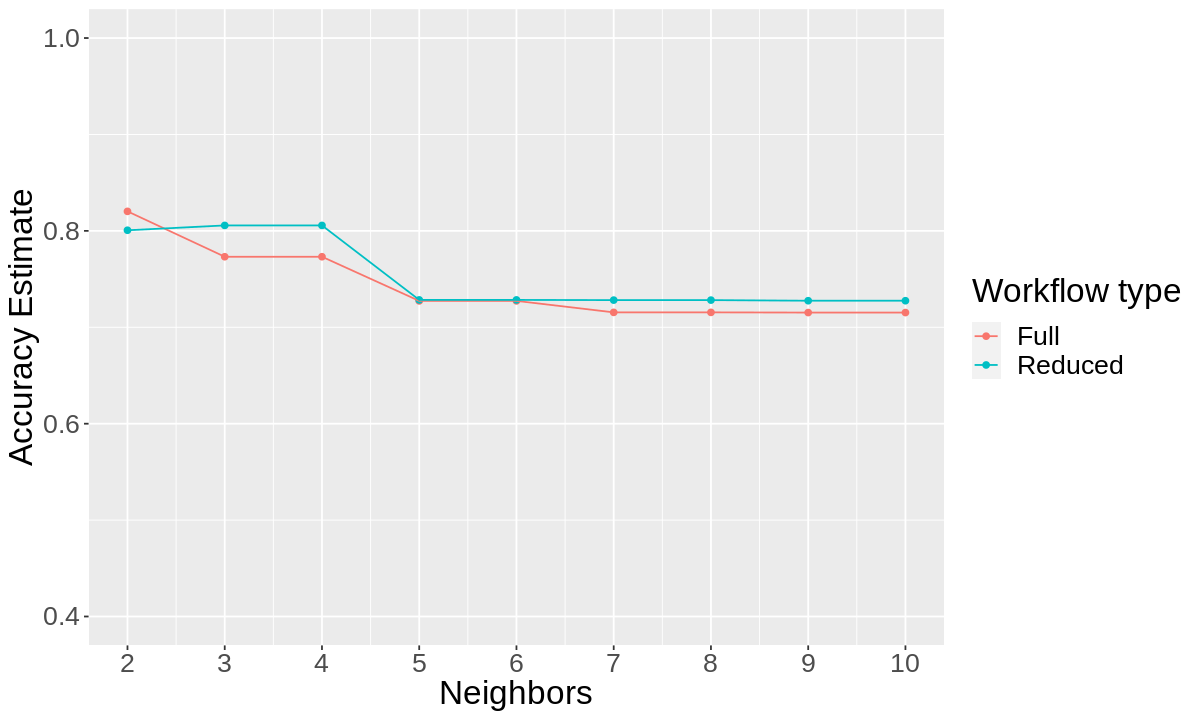

In [13]:
options(repr.plot.height = 6, repr.plot.width = 10)
cross_plot_data <- bind_rows(mutate(metrics_full, id = as_factor("f")), 
                             mutate(metrics_reduced, id = as_factor("r")))|>
                    filter(.metric == "accuracy")
cross_val_plot <- cross_plot_data |> 
    ggplot(aes(x = neighbors, y = mean, color = id)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", color = "Workflow type", f = "full")+
    scale_x_continuous(breaks = seq(0, 10, by = 1)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.4, 1.0)) + # adjusting the y-axis
    theme(text = element_text(size = 20)) +
    scale_colour_discrete(labels = c("Full", "Reduced"))
cross_val_plot
# cross_plot_data


- Excluding bands "X50" to "X60" (reduced) results in a classifier with higher accuracy compared to full aside from when neighbours is equal to 2 to 2.5
- We will choose the 3 neighbours with the reduced workflow type as it yields the highest accuracy estimate

In [14]:
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |> 
    set_engine("kknn") |> 
    set_mode("classification")

workflow_final <- workflow()|> 
    add_recipe(recipe_reduced)|> 
    add_model(knn_spec_final)|>
    fit(data = sonar_train)

sonar_predictions <- predict(workflow_final, sonar_test)|>
    bind_cols(sonar_test)

sonar_metrics <- sonar_predictions|> 
    metrics(truth = type, estimate = .pred_class)

sonar_conf_mat <- sonar_predictions|>
    conf_mat(truth = type, estimate = .pred_class)

sonar_metrics
sonar_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8490566
kap,binary,0.6945245


          Truth
Prediction  R  M
         R 19  2
         M  6 26

- A new model specification is created with the previously determined best parameter value (i.e., K = 3)
- The recipe and model specification is added to a "workflow()" and we retrain the classifier using the "fit()" function
- The class labels for our test set are predicted using the "predict()" function and "bind_cols()" is applied to add the column of predictions to the original test data creating the predictions data frame
- The estimated accuracy of the classifier is evaluated on the test set using the "metrics()" function
- A confusion matrix is created for the classifier using "conf_mat()" which shows the table of predicted labels and correct labels

## Results

The results of the classification model on the test data are:
- Accuracy: 0.8490566 

The confusion matrix shows that out of 47 test instances:  
- 19 instances of type "Rock" (labelled as R) were correctly predicted as "Rock" (R) 
- 26 instances of type "Mine" (labelled as M) were correctly predicted as "Mine" (M) 
- 2 instances of type "Rock" (R) were incorrectly predicted as "Mine" (M) 
- 6 instances of type "Mine" (M) were incorrectly predicted as "Rock" (R)


## Discussion

The KNN classification model achieved an accuracy of 0.849 on the test data. The classifier correctly predicted the majority of instances for both "Rock" and "Mine" types, but there were some misclassifications with 2 instances of "Rock" being predicted as "Mine" and 6 instances of "Mine" being predicted as "Rock". These accuracies fit within what we expected to find, as both mines and rocks were seen to have different mean measurement values in Fig. 1. Some inaccuracies were also expected as some mean measurement values were similar in value to each other.

A classifier that accurately classifies rocks from naval mines opens possibilities in developing autonomous or A.I. directed applications. With current technology, detecting and clearing naval mines with the use of specialized equipment and human operators analyzing sonar imagery for mine detection can be a resource-intensive costly procedure (Gebhardt et al., 2017). A classifier that can accurately distinguish between rocks and naval mines can potentially lead to reductions in cost and labor. When human operators are responsible for mine detection, there are limiting factors such as human error through “drowsiness or nervousness” (Gebhardt et al., 2017) that may result in missing a naval mine or falsely identifying objects as naval mines; such limitations can be prevented through the development of an accurate classifier that would increase the efficiency of mine clearing operations by reducing the amount of time needed to identify a naval mine without direct mistake-prone human examination.

## References

D. Köhntopp, B. Lehmann, D. Kraus, & A. Birk. (2019). Classification and Localization of Naval Mines With Superellipse Active Contours. _IEEE Journal of Oceanic Engineering, 44_(3), 767–782. https://doi.org/10.1109/JOE.2018.2835218
